Package Imports

In [0]:
import numpy as np
import pandas as pd
from collections import Counter

# imports for Part II
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import matplotlib.pyplot as plt


# **Part I**

### 1. K-NearestNeighbour Algorithm

In [0]:
def KNN(X_train, X_test, y_train, k=8):
  """:type X_train: numpy.ndarray
      :type X_test: numpy.ndarray
      :type Y_train: numpy.ndarray
      :rtype: numpy.ndarray"""
      
  X_train = X_train.to_numpy()
  X_test = X_test.to_numpy()
  y_train = y_train.to_numpy()
  y_pred   = []
  distance = [np.sqrt(np.sum(np.square(np.subtract(X_train, X_test[i])),axis=1)) for i in range(len(X_test))]
  distance = np.asarray(distance)
  for i in range(0,distance.shape[0]):
    distance_value = distance[i]
    indexes = distance_value.argsort()
    class_pred = y_train[indexes]
    mode = Counter(class_pred[0:k])
    y_pred.append(mode.most_common(1)[0][0])
  return y_pred

### 2. Random Forest

In [0]:
def RandomForest(X_train, Y_train, X_test):
    """:type X_train: numpy.ndarray
       :type X_test: numpy.ndarray
       :type Y_train: numpy.ndarray
       :rtype: numpy.ndarray"""

    class RandomForestClassifier:
        def __init__(self, X, y, max_samples, max_features=10, n_estimators=10, max_depth=6, min_samples_leaf=1):
            np.random.seed(50)
            self.X, self.y = X, y
            self.n_estimators = n_estimators            # Number of Trees in a forest, default = 20
            self.max_depth = max_depth                  # Maximum depth of a tree, default = None.
            self.max_features = max_features            # Maximum number of features to pass onto each tree.
            self.min_sample_leaf = min_samples_leaf     # Minimum number of samples to be present in a leaf.
            self.max_samples = max_samples              # Maximum random samples to draw from X.
            self.unique_elements = np.unique(self.y)
            self.trees = [self.grow_tree() for tree in range(n_estimators)]

        def grow_tree(self):                            # Convert to fit if to pass only X and y
            indices = np.random.permutation(len(self.y))[:self.max_samples]
            feature_indices = np.random.permutation(self.X.shape[1])[:self.max_features]
            tree = DecisionTree(self.X.iloc[indices], self.y.iloc[indices], self.unique_elements, self.max_features, feature_indices, indices=np.array(range(self.max_samples)), max_depth=self.max_depth, min_sample_leaf = self.min_sample_leaf)
            return tree

        def predict(self, X_test):
            predicted = [tree.predict(X_test) for tree in self.trees]
            column_mode = pd.DataFrame(predicted)
            mode_df = []
            for x in column_mode.columns:
                mode = Counter(column_mode[x])
                mode = mode.most_common()[0][0]
                mode = mode_df.append(mode)
            self.random_forest_predictions = pd.DataFrame(mode_df)
            self.random_forest_predictions = (self.random_forest_predictions.reset_index(drop=True)).to_numpy()
            return self.random_forest_predictions

        def calculate_accuracy(self, y_test):
            y_test = (y_test.reset_index(drop=True)).to_numpy()
            accuracy = np.sum(np.where(self.random_forest_predictions.flatten()==y_test.flatten(),1,0))/(len(y_test))
            return accuracy*100


    class DecisionTree:
        def __init__(self, X, y, master_unique_elements, max_features, feature_indices, indices, max_depth, min_sample_leaf):
            self.X = X
            self.y = y
            self.max_features = max_features
            self.indices = indices
            self.feature_indices = feature_indices
            self.max_depth = max_depth
            self.min_sample_leaf = min_sample_leaf
            self.m = len(indices)                       # Number of samples
            self.n = X.shape[1]                         # Number of features
            self.master_unique_elements = master_unique_elements
            self.unique_elements = list(set(self.y))
            self.target_count = [self.unique_elements.count(target) for target in self.master_unique_elements]
            self.score = float('inf')                   # Initiating a Inf Score
            self.classify = float('inf')
            if len(np.unique(self.y.values[self.indices])) == 1 or (self.max_depth <= 0) or (len(self.indices) <= min_sample_leaf): # 
                self.classify = self.classification(y.values[self.indices])
            else:
                self.grow_tree()

        def split_data(self):
            return self.X.values[self.indices, self.feature_index]

        def classification(self, y):
            unique_classes, counts = np.unique(y, return_counts=True)
            classification = unique_classes[counts.argmax()]
            return classification

        def grow_tree(self):
            for feature_index in range(self.max_features):
                self.best_split(feature_index)
            if self.score == float('inf') or self.max_depth <= 0:
                return
            data_split = self.split_data()
            left = np.nonzero(data_split <= self.split_threshold)
            right = np.nonzero(data_split > self.split_threshold)
            if len(left)== 0 or len(right) == 0:
                self.classify = self.classification(self.y.values[self.indices])
            left_indices = np.random.permutation(self.X.shape[1])[:self.max_features]
            right_indices = np.random.permutation(self.X.shape[1])[:self.max_features]
            self.left = DecisionTree(self.X, self.y, self.master_unique_elements, self.max_features, left_indices, self.indices[left], max_depth=self.max_depth-1, min_sample_leaf=self.min_sample_leaf)
            self.right = DecisionTree(self.X, self.y, self.master_unique_elements, self.max_features, right_indices, self.indices[right], max_depth=self.max_depth-1, min_sample_leaf=self.min_sample_leaf)

        def calculate_entropy(self, y):
            _, counts = np.unique(y, return_counts=True)
            prob = counts / counts.sum()
            entropy = sum(prob * -np.log2(prob))
            return entropy

        def calculate_column_entropy(self, below_threshold, above_threshold, y_data_below, y_data_above):
            n = len(below_threshold) + len(above_threshold)
            prob_below_threshold = len(below_threshold) / n
            prob_above_threshold = len(above_threshold) / n
            overall_entropy = (prob_below_threshold * self.calculate_entropy(y_data_below) + prob_above_threshold * self.calculate_entropy(y_data_above))
            return overall_entropy

        def best_split(self, feature_index):
            X, y = self.X.values[self.indices, feature_index], self.y.values[self.indices]
            sorted_indices = np.argsort(X)
            sort_x, sort_y = X[sorted_indices], y[sorted_indices]
            # Entropy Calculation
            for row in range(self.m-1):
                data_below = sort_x[:row+1]
                data_above = sort_x[row+1:]
                current_X = sort_x[row]
                y_data_below = sort_y[:row+1]
                y_data_above = sort_y[row+1:]
                current_score = self.calculate_column_entropy(data_below, data_above, y_data_below, y_data_above)
                if X[row] == X[row-1]:
                    continue
                if current_score < self.score:
                    self.feature_index, self.score, self.split_threshold = feature_index, current_score, current_X

        def predict(self, X_test):
            X_test = np.array(X_test)
            predicted = np.array([self.predict_row(predict) for predict in X_test])
            return predicted


        def predict_row(self, predict):
            if self.max_depth == 0 or self.classify != float('inf'):
                if self.classify != float('inf'):
                    return self.classify
                else:
                    return int(self.y[self.indices].mode().sample(1))
            predicted = self.left if predict[self.feature_index] <= self.split_threshold else self.right
            return predicted.predict_row(predict)


    random_forest_classifier = RandomForestClassifier(X_train, Y_train, 950, 30, 20, 11)
    y_pred = random_forest_classifier.predict(X_test)
    # print("Accuracy of Random Forest: " + str(random_forest_classifier.calculate_accuracy(y_test)))
    return y_pred

### 3. PCA

In [0]:
def PCA(X_train, N):
    """
    :type X_train: numpy.ndarray
    :type N: int
    :rtype: numpy.ndarray
    """
    covariance_matrix = np.cov(X_train.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    eigen_pairs = []

    for i in range(0,len(eigen_values)):
      eigen_pairs.append([np.abs(eigen_values[i]), eigen_vectors[:,i]])

    eigen_pairs.sort(reverse = True)
    result = 0
    for i in eigen_pairs:
      if (i[0]/sum(eigen_values) * 100 > 1):
        result+=i[0]/sum(eigen_values) * 100
    
    transformed_matrix = []

    for i in range(0,N):
      transformed_matrix.append(eigen_pairs[i][1])

    transformed_matrix = np.asarray(transformed_matrix)
    transformed_matrix = transformed_matrix.reshape(len(data.columns)-1,N)
    Y = data_features.dot(transformed_matrix)
    return Y

### 4. K-Means Clustering

In [0]:
def Kmeans(X_train, N):
    """:type X_train: numpy.ndarray
     :type N: int
     :rtype: List[numpy.ndarray]"""
    input_X = np.array(X_train)
    centroids = input_X[np.random.choice(input_X.shape[0], N, replace=False)]
    for i in range(200):
        old_centroids = centroids
        distance = np.zeros((input_X.shape[0], N))
        intermediate_centroids = np.zeros((N, input_X.shape[1]))

        for i in range(N):
            row_norm = norm(input_X - old_centroids[i, :], axis=1)
            distance[:, i] = np.square(row_norm)

        classes = np.argmin(distance, axis=1)

        for j in range(N):
            intermediate_centroids[j, :] = np.mean(input_X[classes == j, :], axis=0)

        centroids = intermediate_centroids
        if np.all(old_centroids == centroids):
            break
            
    cluster_list = [input_X[classes == i] for i in range(N)]
    return cluster_list

In [0]:
def Accuracy(y_true, y_pred):
  """:type y_true: numpy.ndarray
     :type y_pred: numpy.ndarray
     :rtype: float"""
     
  accuracy = 0
  for true, pred in zip(y_true,y_pred):
    if true == pred:
      accuracy += 1
  return (accuracy/len(y_true) * 100)

### 6. Recall

In [0]:
def Recall(y_true, y_pred):
     """:type y_true: numpy.ndarray
        :type y_pred: numpy.ndarray
        :rtype: float"""
        
     confusion_matrix = ConfusionMatrix(y_true,y_pred)
     rows, columns = confusion_matrix.shape
     total_sum = 0
     for label in range(columns):
         row = confusion_matrix[label, :] 
         a = confusion_matrix[label, label] / row.sum()
         total_sum += a
     return total_sum / columns

### 7. Precision

In [0]:
def Precision(y_true, y_pred):
    """:type y_true: numpy.ndarray
       :type y_pred: numpy.ndarray
       :rtype: float"""
       
    confusion_matrix = ConfusionMatrix(y_true,y_pred)
    rows, columns = confusion_matrix.shape
    total_sum = 0
    for label in range(rows):
        col = confusion_matrix[:, label]
        a =  confusion_matrix[label, label] / col.sum()
        total_sum += a
    return total_sum / rows

### 8. Within Cluster Sum of Squares (WCSS)


In [0]:
def WCSS(clusters):
    """:Clusters List[numpy.ndarray]
       :rtype: float"""
    wcss = 0
    m = 0
    for x in clusters:
      wcss+= np.sum(np.square((np.subtract(np.mean(x,axis=0),clusters[m]))))
      m+=1
    return wcss

# **Part II**

### Implementation of Supervised Algorithms: SVM, Logistics Regression, Decision Tree, and KNN using Scikit-learn

In [0]:
def SklearnSupervisedLearning(X_train, Y_train, X_test):
    """:type X_train: numpy.ndarray
       :type X_test: numpy.ndarray
       :type Y_train: numpy.ndarray
       :rtype: List[numpy.ndarray]"""
    
    y_preds = []
    # SVM implementation in Sklearn
    svm = SVC(kernel='rbf', C = 10, gamma=1)
    svm_model = svm.fit(X_train, Y_train)
    svm_pred = svm_model.predict(X_test)

    # Logistic Regression implementation using Sklearn.
    logistic_regression = LogisticRegression(max_iter=10000,C=50)
    logistic_model = logistic_regression.fit(X_train, Y_train)
    logistic_pred = logistic_model.predict(X_test)

    # Decision Tree implementation using Sklearn
    
    gini_tree = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=7, min_samples_leaf=5)
    decisiontree_model = gini_tree.fit(X_train, Y_train)
    decision_tree_pred = decisiontree_model.predict(X_test)

    # KNN implementation using Sklearn
    knn = KNeighborsClassifier(n_neighbors=8)
    knn_model = knn.fit(X_train, Y_train)
    knn_pred = knn.predict(X_test)

    # List of predictions by Sklearn Models
    y_preds = [svm_pred, logistic_pred, decision_tree_pred, knn_pred]
    return y_preds

### Ensemble model using the voting classifier

In [0]:
def SklearnVotingClassifier(X_train, Y_train, X_test):
    """:type X_train: numpy.ndarray
       :type X_test: numpy.ndarray
       :type Y_train: numpy.ndarray
       :rtype: List[numpy.ndarray]"""
       
    estimators = []
    svm = SVC(kernel='rbf', C = 10, gamma=1)
    estimators.append(('svm', svm))
    svm_model = svm.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)

    logistic_regression = LogisticRegression(max_iter=10000, C=50)
    estimators.append(('logistic', logistic_regression))
    logistic_model = logistic_regression.fit(X_train, y_train)
    logistic_pred = logistic_model.predict(X_test)

    gini_tree = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=8, min_samples_leaf=5)
    estimators.append(('decision', gini_tree))
    decisiontree_model = gini_tree.fit(X_train, y_train)
    decision_tree_pred = decisiontree_model.predict(X_test)

    knn = KNeighborsClassifier(n_neighbors=8)
    estimators.append(('knn', knn))
    knn_model = knn.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)

    ensemble = VotingClassifier(estimators)
    ensemble_model = ensemble.fit(X_train, y_train)
    ensemble_pred = ensemble_model.predict(X_test)

    y_preds = [logistic_pred, decision_tree_pred, svm_pred, knn_pred, ensemble_pred]
    return y_preds

### Confusion Matrix

In [0]:
def ConfusionMatrix(y_true, y_pred):
    """:type y_true: numpy.ndarray
       :type y_pred: numpy.ndarray
       :rtype: float"""
        
    result = np.zeros((12, 12))
    for i, j in zip(y_true, y_pred):
      i = int(i)
      j = int(j)
      result[i][j] += 1
    result = np.delete(result, (0), axis=0)
    result = np.delete(result, (0), axis=1)
    return result

In [0]:
def confusion_matrix_plot(confusion_matrix, ax):
    ax.imshow(np.array(confusion_matrix), cmap=plt.get_cmap("Pastel1"), interpolation='nearest') 
    for x in range(len(confusion_matrix)):
        for y in range(len(confusion_matrix[0])):
            ax.annotate(int(confusion_matrix[x][y]), xy=(y, x), horizontalalignment='center',verticalalignment='center')

    ylabels=['1','2','3','4','5','6','7','8','9','10','11']
    xlabels=['1','2','3','4','5','6','7','8','9','10','11']
    ax.set_yticks(range(confusion_matrix.shape[0]))
    ax.set_yticklabels(ylabels)
    ax.set_xticks(range(confusion_matrix.shape[1]))
    ax.set_xticklabels(xlabels)
    plt.style.use('classic')

def confusion_matrix_plots(y_preds_ensemble):
    fig,(ax0,ax1, ax2,ax3, ax4) = plt.subplots(nrows=1, ncols=5, sharey=False, sharex=False, figsize=(40,50))
    fig.patch.set_facecolor('xkcd:white')
    ax0.set_title('Logistic Confusion Matrix')
    ax1.set_title('Decision Tree Confusion Matrix')
    ax2.set_title('SVM Confusion Matrix')
    ax3.set_title('KNN Confusion Matrix')
    ax4.set_title('Ensemble Confusion Matrix')
    confusion_matrix_plot(ConfusionMatrix(y_test, y_preds_ensemble[0]), ax0)
    confusion_matrix_plot(ConfusionMatrix(y_test, y_preds_ensemble[1]), ax1)
    confusion_matrix_plot(ConfusionMatrix(y_test, y_preds_ensemble[2]), ax2)
    confusion_matrix_plot(ConfusionMatrix(y_test, y_preds_ensemble[3]), ax3)
    confusion_matrix_plot(ConfusionMatrix(y_test, y_preds_ensemble[4]), ax4)
    

### Grid Search Plots

In [0]:
def GridSearchPlot(X_train, y_train):

  # KNN
  params_knn = {'n_neighbors': np.arange(1, 10)}
  knn_gs = GridSearchCV(KNeighborsClassifier(), params_knn, cv=5)
  knn_gs.fit(X_train, y_train)
  knn_results = knn_gs.cv_results_
  mean_test_knn = knn_results['mean_test_score']
  neighbours_knn = [i['n_neighbors'] for i in knn_results['params']]

  # DecisionTree
  param_grid = {'max_depth': np.arange(2, 11)}
  tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
  tree.fit(X_train, y_train)
  decision_tree_results = tree.cv_results_
  mean_test_tree = decision_tree_results['mean_test_score']
  neighbours_tree = [i['max_depth'] for i in decision_tree_results['params']]

  # SVM
  Cs = [0.001, 0.01, 0.1, 1]
  param_grid = {'C': Cs}
  svm_gs = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=5)
  svm_gs.fit(X_train, y_train)
  svm_results = svm_gs.cv_results_
  mean_test_svm = svm_results['mean_test_score']
  neighbours_svm = [i['C'] for i in svm_results['params']]
  return neighbours_knn, mean_test_knn, neighbours_tree, mean_test_tree, neighbours_svm, mean_test_svm

def GridSearchPlots(X_train, y_train):
  neighbours_knn, mean_test_knn, neighbours_tree, mean_test_tree, neighbours_svm, mean_test_svm = GridSearchPlot(X_train, y_train)
  fig,(ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=(20,5))
  fig.patch.set_facecolor('xkcd:white')
  ax0.bar(neighbours_knn, mean_test_knn)
  low, high = min(mean_test_knn), max(mean_test_knn)
  thrd = 0.1*(high-low)
  ax0.set_ylim([low-thrd, high+thrd])
  ax0.set_xlabel('Number of neighbors (k)')
  ax0.set_ylabel('Accuracy')
  ax0.set_xlim(0,10)
  ax0.set_title("Grid Search - KNN Model")
  ax1.bar(neighbours_tree, mean_test_tree)
  ax1.set_xlabel('Maximum Depth (d)')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlim(1,11)
  ax1.set_title("Grid Search - Decision Tree Model")
  ax2.semilogx(neighbours_svm, mean_test_svm, marker='8')
  ax2.set_title("Grid Search - SVM Model")
  ax2.set_xlabel('Hyperparameter C')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim(0,1)
  ax2.grid(True)
  plt.show()


====================================================== End ======================================================




Function Calls

Accuracy of KNN: 98.779296875
Accuracy of Random Forest: 94.6533203125
Kmeans function has been implemented and the clusters are stored in the variable k_mean_clusters
Dimensions reduced to after applying PCA: 10
WCSS Value: 4187.214989574909
Accuracy of SVM using Scikit:  97.6806640625
Accuracy of Logistic using Scikit:  90.19775390625
Accuracy of Decision Tree using Scikit:  87.51220703125
Accuracy of KNN using Scikit:  98.53515625
Accuracy of the ensembled model using voting classifier in Scikit:  97.27783203125


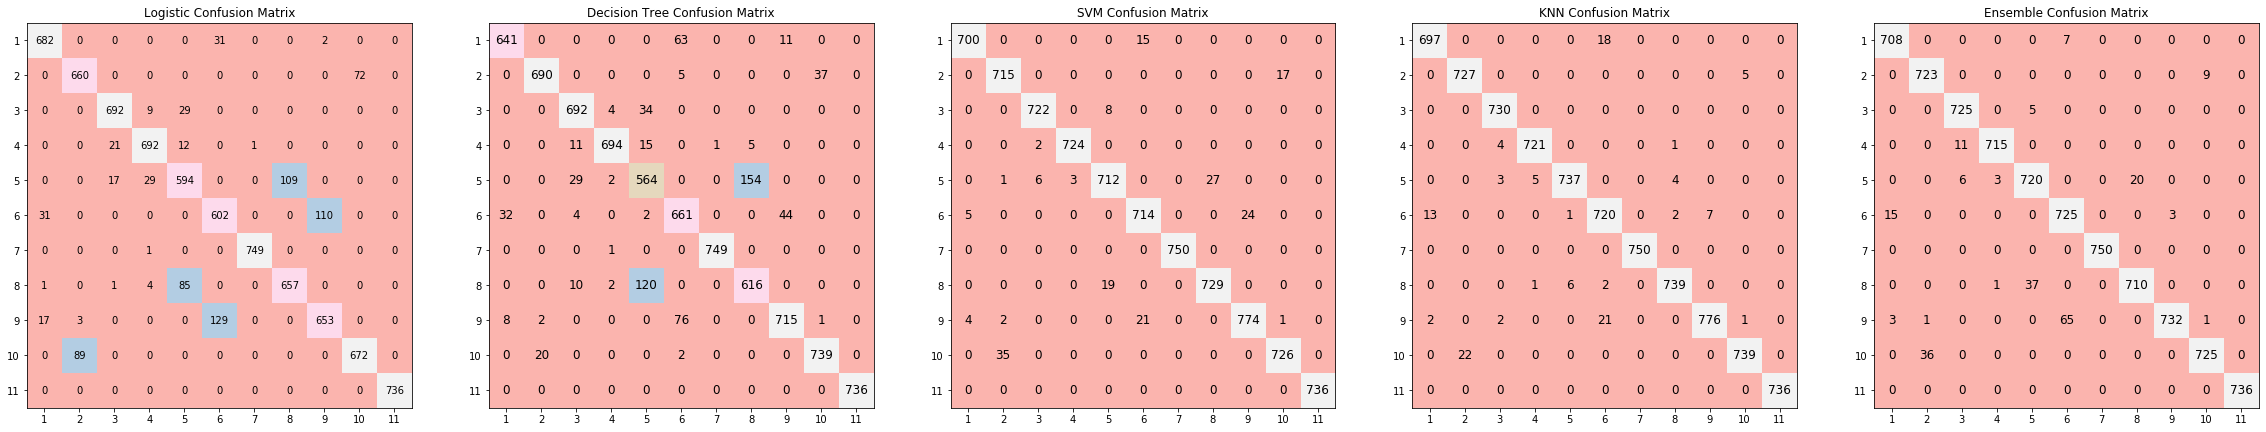

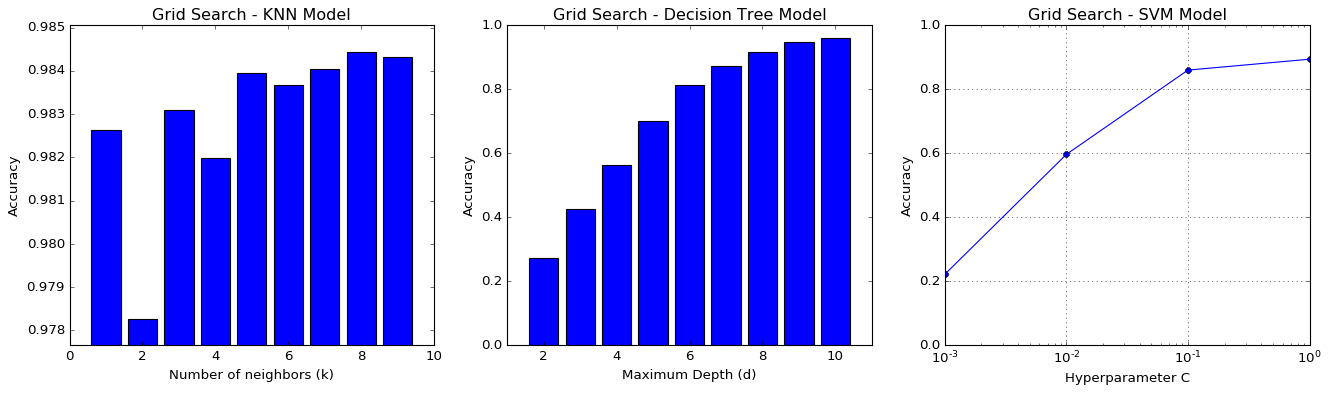

The sample precision value for logistic regression:  0.902453543374596
The sample recall value for logistic regression: 0.9031051778573826
Time:  1929.2531438300002


In [15]:
# Loading Data
input_path = r'data.csv'
data = pd.read_csv(input_path)
data = data.dropna()
data_features = data.loc[:, '0':'47'] # Features
target = data['48']                   # Labels
# Normalizing the inputs. 
data_features = (data_features - data_features.mean())/(data_features.max() - data_features.min())
# Spliting the data.
X_train, X_test, y_train, y_test = train_test_split(data_features, target, test_size=0.2, random_state=50)

import timeit
start = timeit.default_timer()
"""Part I"""
# KNN Function Calls
y_pred_knn = KNN(X_train, X_test, y_train, k=8)                       
accuracy_knn = Accuracy(y_test, y_pred_knn)                           # Return numpy.ndarray of predicted values
print('Accuracy of KNN: '+ str(accuracy_knn))                         # Accuracy of KNN

# Random Forest Function Calls. 
y_pred_randomforest = RandomForest(X_train, y_train, X_test)          # Return numpy.ndarray of predicted values
accuracy_random_forest = Accuracy(y_test, y_pred_randomforest)        # Accuracy of Random Forest
print('Accuracy of Random Forest: '+ str(accuracy_random_forest))

# K-Means Function Calls.
k_mean_clusters = Kmeans(X_train, 11)  
print('Kmeans function has been implemented and the clusters are stored in the variable k_mean_clusters')    # Return List[numpy.ndarray(Clusters)]

# PCA
y_pred_pca = PCA(X_train, 10)
print("Dimensions reduced to after applying PCA: " + str(y_pred_pca.shape[1]))

# WCSS
wcss = WCSS(k_mean_clusters)
print("WCSS Value: "+ str(wcss))

# # """Part II"""
# Implementation of Supervised Algorithms: SVM, Logistics Regression, Decision Tree, and KNN using Scikit-learn 
models = ['SVM', 'Logistic', 'Decision Tree', 'KNN']
y_preds = SklearnSupervisedLearning(X_train, y_train, X_test)
for i, model in enumerate(models):
  accuracy_sklearn_models = Accuracy(y_test, y_preds[i])
  print ('Accuracy of {} using Scikit: '.format(model), str(Accuracy(y_test, y_preds[i])))

# Ensemble model using the voting classifier 
y_preds_ensemble = SklearnVotingClassifier(X_train, y_train, X_test)
print ('Accuracy of the ensembled model using voting classifier in Scikit: '.format(4), str(Accuracy(y_test, y_preds_ensemble[4])))

# Confusion Matrix Plots
confusion_matrix_plots(y_preds_ensemble)

# Grid Search Plots
GridSearchPlots(X_train, y_train)

# Precision and Recall Example for Logistic Regression
print('The sample precision value for logistic regression: ', Precision(y_test, y_preds_ensemble[0]))
print('The sample recall value for logistic regression:',Recall(y_test, y_preds_ensemble[0]))

stop = timeit.default_timer()
print('Time: ', stop - start) 
